In [15]:
import pandas as pd
import json
import numpy
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

In [16]:
transfer_df = pd.read_json('players_transfers.json')
player_df = pd.read_json('Players.json')
merged = pd.merge(player_df,transfer_df,left_on='id',right_on='Player_id')

In [17]:
merged['age'].isna().sum()

106

In [18]:
def subtract_age(row):
    if row["age"] is not None:
        if row['Date'] != '-':
            year = int(row['Date'][-4:])
            return row['age'] - (2023 - year)
        return None    
    else:
        return  None

In [19]:
merged['age_in_transfer'] = merged.apply(subtract_age,axis=1)

In [20]:
merged = merged.loc[:,['id','destination_id','age_in_transfer','Season']]

In [21]:
df = pd.read_json('P2_player_state.json')
df = df.loc[:,['Player_id','Apperance','PPG','Season','Goals','Own_goal','Yellow_card','Red_card','Goals_conceded','Assists','Clean_sheets']]
cols_with_dash = df.columns[df.isin(['-']).any()]
df[cols_with_dash] = df[cols_with_dash].replace('-', 0, regex=True)
df = df.fillna(0)

In [22]:
def convert_to_float(s):
    if s == '':
        return 0.0  # or any other default value you wish to assign
    else:
        return float(s)
df['PPG'] = df['PPG'].str.replace(',','.')
df['PPG'] = df['PPG'].apply(convert_to_float)
df=df.fillna(0)

In [23]:
df = df.rename(columns={'Player_id':'id'})
df = pd.merge(df,merged,on=['id','Season'],how='left')
df.dropna(inplace=True)
df

,id,Apperance,PPG,Season,Goals,Own_goal,Yellow_card,Red_card,Goals_conceded,Assists,Clean_sheets,destination_id,age_in_transfer
0,1020544,7,0.57,22/23,0,0,1,0,0,0,0,3524.0,20.0
1,1020544,7,0.57,22/23,0,0,1,0,0,0,0,541.0,19.0
2,1020544,7,0.57,22/23,0,0,1,0,0,0,0,3524.0,19.0
3,1020544,1,0.00,22/23,0,0,0,0,0,0,0,3524.0,20.0
4,1020544,1,0.00,22/23,0,0,0,0,0,0,0,541.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342216,10,6,1.67,11/12,3,0,0,0,0,3,0,398.0,32.0
342228,10,27,2.11,07/08,10,0,2,0,0,8,0,27.0,28.0
342229,10,12,1.50,07/08,5,0,0,0,0,1,0,27.0,28.0
342230,10,6,3.00,07/08,5,0,0,0,0,2,0,27.0,28.0


In [24]:
df_temp = pd.read_json('table_for_statistics.json')
df_temp = df_temp.loc[:,['id','main_position']]
mid_pos = ['Central Midfield', 'Attacking Midfield', 'Defensive Midfield','Left Midfield', 'Right Midfield']
att_pos = ['Centre-Forward','Right Winger', 'Left Winger','Second Striker']
def_pos = ['Centre-Back','Left-Back','Right-Back']
df_temp['pos'] = 'GK'
df_temp.loc[df_temp['main_position'].isin(mid_pos), 'pos'] = 'MID'
df_temp.loc[df_temp['main_position'].isin(att_pos), 'pos'] = 'ATT'
df_temp.loc[df_temp['main_position'].isin(def_pos), 'pos'] = 'DEF'
df_temp = df_temp.drop(columns='main_position')

In [25]:
df = pd.merge(df, df_temp, on='id', how='left')
df.dropna(inplace=True)
df

,id,Apperance,PPG,Season,Goals,Own_goal,Yellow_card,Red_card,Goals_conceded,Assists,Clean_sheets,destination_id,age_in_transfer,pos
0,1020544,7,0.57,22/23,0,0,1,0,0,0,0,3524.0,20.0,MID
1,1020544,7,0.57,22/23,0,0,1,0,0,0,0,541.0,19.0,MID
2,1020544,7,0.57,22/23,0,0,1,0,0,0,0,3524.0,19.0,MID
3,1020544,1,0.00,22/23,0,0,0,0,0,0,0,3524.0,20.0,MID
4,1020544,1,0.00,22/23,0,0,0,0,0,0,0,541.0,19.0,MID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213539,215,1,3.00,14/15,2,0,0,0,0,0,0,3711.0,33.0,ATT
213540,215,31,1.13,13/14,6,0,1,0,0,4,0,1084.0,31.0,ATT
213541,215,1,1.00,13/14,0,0,0,0,0,0,0,1084.0,31.0,ATT
213542,215,31,1.42,12/13,8,0,2,0,0,2,0,281.0,31.0,ATT


In [26]:
co_attack = [1,3,2,-1,-.5,-2,0,1,0] 
co_mid = [1,3,1,-1,-.5,-1.5,0,1,0]  
co_deff = [2,3,1,-1,-.5,-1,0,1,0]
co_gk = [3,3,0,-1,-.5,-1.5,-.5,0,1]
input = df.drop(columns=['id','pos','age_in_transfer','Season','destination_id'])
input = input.astype(int)
output_att = pd.DataFrame(input.values * co_attack, columns=input.columns)
output_def = pd.DataFrame(input.values * co_deff, columns=input.columns)
output_mid = pd.DataFrame(input.values * co_mid, columns=input.columns)
output_gk = pd.DataFrame(input.values * co_gk, columns=input.columns)
output_att['row_sum'] = output_att.sum(axis=1)
output_def['row_sum'] = output_def.sum(axis=1)
output_mid['row_sum'] = output_att.sum(axis=1)
output_gk['row_sum'] = output_att.sum(axis=1)

In [27]:
df['Rating'] = 0
df=df.reset_index(drop=True)
for i in range(len(df)):
    if df.loc[i, 'pos'] == 'ATT':
        df.loc[i,'Rating'] = max(0,min(output_att.loc[i, 'row_sum'],100))
    elif df.loc[i, 'pos'] == 'DEF':
        df.loc[i,'Rating'] = max(0,min(output_def.loc[i, 'row_sum'],100))
    elif df.loc[i, 'pos'] == 'GK':
        df.loc[i,'Rating'] = max(0,min(output_gk.loc[i, 'row_sum'],100))
    elif df.loc[i, 'pos'] == 'MID':
        df.loc[i,'Rating'] = max(0,min(output_mid.loc[i, 'row_sum'],100))

In [28]:
df

,id,Apperance,PPG,Season,Goals,Own_goal,Yellow_card,Red_card,Goals_conceded,Assists,Clean_sheets,destination_id,age_in_transfer,pos,Rating
0,1020544,7,0.57,22/23,0,0,1,0,0,0,0,3524.0,20.0,MID,13.0
1,1020544,7,0.57,22/23,0,0,1,0,0,0,0,541.0,19.0,MID,13.0
2,1020544,7,0.57,22/23,0,0,1,0,0,0,0,3524.0,19.0,MID,13.0
3,1020544,1,0.00,22/23,0,0,0,0,0,0,0,3524.0,20.0,MID,2.0
4,1020544,1,0.00,22/23,0,0,0,0,0,0,0,541.0,19.0,MID,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190144,215,1,3.00,14/15,2,0,0,0,0,0,0,3711.0,33.0,ATT,14.0
190145,215,31,1.13,13/14,6,0,1,0,0,4,0,1084.0,31.0,ATT,49.5
190146,215,1,1.00,13/14,0,0,0,0,0,0,0,1084.0,31.0,ATT,4.0
190147,215,31,1.42,12/13,8,0,2,0,0,2,0,281.0,31.0,ATT,51.0


In [29]:
olds = df[df.age_in_transfer >= 30]['Rating'].values
youngs = df[df.age_in_transfer < 30]['Rating'].values

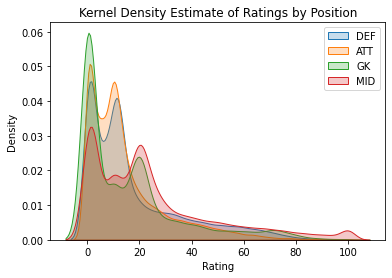

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the DataFrame by 'pos' column and get the 'Rating' column
def_ratings = df[df['pos'] == 'DEF']
att_ratings = df[df['pos'] == 'ATT']
gk_ratings = df[df['pos'] == 'GK']
mid_ratings = df[df['pos'] == 'MID']
sns.kdeplot(data=def_ratings, x='Rating', label='DEF', fill=True)
sns.kdeplot(data=att_ratings, x='Rating', label='ATT', fill=True)
sns.kdeplot(data=gk_ratings, x='Rating', label='GK', fill=True)
sns.kdeplot(data=mid_ratings, x='Rating', label='MID', fill=True)
# Add a legend, axis labels, and title to the plot
plt.legend(loc='upper right')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Ratings by Position')
plt.show()

In [33]:
t_stat, p_value = ttest_ind(olds, youngs)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 4.300176575640066
P-value: 1.7074695654190654e-05


The t-statistic measures the difference between the means of the two groups in units of standard error. The p-value indicates the probability of observing a t-statistic as extreme as the one computed from our data, assuming the null hypothesis (that there is no difference between the means of the two groups)is true. If the p-value is less than the significance level (usually 0.05), then we reject the null hypothesis and conclude that the means of the two groups are significantly different

In [34]:
if olds.mean()>youngs.mean():
    print("The hypothesis was correct because, firstly, these players' ratings\nare not from the same distribution, and secondly, the mean ranking of\nthe oldest players is better than that of the youngest players..")
else:
    print("The hypothesis was incorrect because, firstly, these players' ratings\n are  not from the same distribution, and secondly, the mean ranking of\n the youngest players is better than that of the oldest players..")

The hypothesis was correct because, firstly, these players' ratings
are not from the same distribution, and secondly, the mean ranking of
the oldest players is better than that of the youngest players..
